# 07.07 - Modeling - Prophet + Nearest Neighbors Regression

## Imports & setup

In [1]:
import pathlib
import warnings
from datetime import datetime
import sys
import pickle
import joblib
import gc

import pandas as pd
import numpy as np

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates


# Imports
sys.path.append("..")
from src.utils.utils import (AnnualTimeSeriesSplit,
                             RollingAnnualTimeSeriesSplit,
                             bound_precision,
                             run_cross_val,
                             run_data_split_cross_val,
                             save_run_results)
from src.features.features import CyclicalToCycle
from src.models.models import SK_SARIMAX, SK_Prophet, SetTempAsPower, SK_Prophet_1
from src.visualization.visualize import (plot_prediction,
                                         plot_joint_plot,
                                         residual_plots,
                                         print_residual_stats,
                                         resids_vs_preds_plot)
#b # Packages
from sklearn.pipeline import Pipeline
from skoot.feature_selection import FeatureFilter
from skoot.preprocessing import SelectiveRobustScaler
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from fbprophet import Prophet
from xgboost.sklearn import XGBRegressor

# Display
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
figsize=(15,7)
warnings.filterwarnings(action='ignore')
%matplotlib inline

# Data
PROJECT_DIR = pathlib.Path.cwd().parent.resolve()
CLEAN_DATA_DIR = PROJECT_DIR / 'data' / '05-clean'
MODELS_DIR = PROJECT_DIR / 'data' / 'models'
RESULTS_PATH = PROJECT_DIR / 'data' /'results' / 'results.csv'

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


## Load Daily Data & Inspect

In [2]:
df = pd.read_csv(CLEAN_DATA_DIR / 'clean-features.csv', parse_dates=True, index_col=0)

In [3]:
X = df.copy(deep=True)
X = X.loc['1994': '2008']
y = X.pop('daily_peak')
X.head()

,hmdxx_min,hmdxx_max,hmdxx_median-1,hmdxx_max_hour,temp_min,temp_max,dew_point_temp_max,sun_rise,sun_set,visibility_mean,day_of_week,week_of_year,day_type
1994-05-24,8.998045,19.818202,19.655075,15.0,9.0,19.6,13.4,6.0,21.0,24.975000,1.0,21.0,2
1994-05-25,11.406291,20.665711,17.205396,18.0,10.4,18.2,14.0,6.0,21.0,9.358333,2.0,21.0,0
1994-05-26,2.563201,15.259916,17.722172,2.0,3.9,13.0,12.3,6.0,21.0,9.650000,3.0,21.0,0
1994-05-27,-0.012865,12.970553,6.567827,17.0,2.0,14.8,2.3,6.0,21.0,34.500000,4.0,21.0,0
1994-05-30,13.632519,30.133976,18.724332,14.0,13.1,27.2,13.6,6.0,21.0,22.270833,0.0,22.0,0


In [4]:
y.tail()

2008-09-29    18338.0
2008-09-30    17977.0
2008-10-01    18168.0
2008-10-02    18256.0
2008-10-03    17495.0
Name: daily_peak, dtype: float64

## Prophet Model + XGBoost Residuals Model

In [5]:
N_SPLITS = 10
from sklearn.neighbors import KNeighborsRegressor

def run_model(X,y, param=None):

    scores_dicts = {'train':
                        {'mae': [],
                         'bound': []},
                    'test':
                        {'mae': [],
                         'bound': []}}
    
    # Pre-processing
    # Robust Scaling
    robust_scaler_cols = ['hmdxx_min', 'hmdxx_max', 'hmdxx_median-1', 'temp_min','temp_max',
                          'dew_point_temp_max', 'visibility_mean']
    # Cyclical Transform
    rscaler = SelectiveRobustScaler(cols=robust_scaler_cols, trans_col_name=robust_scaler_cols)
    cyclical0 = CyclicalToCycle(cycle_name='hmdxx_max_hour', periods_per_cycle=24)
    cyclical1 = CyclicalToCycle(cycle_name='sun_rise', periods_per_cycle=24)
    cyclical2 = CyclicalToCycle(cycle_name='sun_set', periods_per_cycle=24)
    cyclical3 = CyclicalToCycle(cycle_name='day_of_week', periods_per_cycle=24)
    cyclical4 = CyclicalToCycle(cycle_name='week_of_year', periods_per_cycle=24)
    
    # Prophet
    factor = 0.05
    seas_factor = 0.05
    mode = 'multiplicative'
    regressors = {'hmdxx_min': (factor, False, mode),
                  'hmdxx_max': (factor, False, mode),
                  'hmdxx_median-1': (factor, False, mode),
                  'sin_hmdxx_max_hour': (seas_factor, False, mode),
                  'cos_hmdxx_max_hour': (seas_factor, False, mode),
                  'temp_min': (factor, False, mode),
                  'temp_max': (factor, 'auto', mode),
                  'dew_point_temp_max': (factor, False, mode),
                  'sin_sun_rise': (factor, False, mode),
                  'cos_sun_rise': (factor, False, mode),
                  'sin_sun_set': (factor, False, mode),
                  'cos_sun_set': (factor, False, mode),
                  'sin_day_of_week': (factor, False, mode),
                  'cos_day_of_week': (factor, False, mode),
                  'sin_week_of_year': (factor, False, mode),
                  'cos_week_of_year': (factor, False, mode),
                  'visibility_mean': (factor, False, mode),
                  'day_type': (factor, False, mode)}

    prophet_model = SK_Prophet_1(regressors=regressors,
                           pred_periods=96)


    # Residuals model
    resid_model = KNeighborsRegressor(n_neighbors=10, weights='distance')


    ratscv = RollingAnnualTimeSeriesSplit(n_splits=N_SPLITS, goback_years=5)

    for train_indces, test_indces in ratscv.split(X, y):       
        X_train = X.iloc[train_indces]; y_train = y.iloc[train_indces]
        X_test = X.iloc[test_indces] ; y_test = y.iloc[test_indces]

        # Pre-processing Cyclic features
        cyclical0.fit(X_train, y_train)
        X_t_train = cyclical0.transform(X_train)
        X_t_test = cyclical0.transform(X_test)
        
        cyclical1.fit(X_t_train, y_train)
        X_t_train = cyclical1.transform(X_t_train)
        X_t_test = cyclical1.transform(X_t_test)
        
        cyclical2.fit(X_t_train, y_train)
        X_t_train = cyclical2.transform(X_t_train)
        X_t_test = cyclical2.transform(X_t_test)

        cyclical3.fit(X_t_train, y_train)
        X_t_train = cyclical3.transform(X_t_train)
        X_t_test = cyclical3.transform(X_t_test)
        
        cyclical4.fit(X_t_train, y_train)
        X_t_train = cyclical4.transform(X_t_train)
        X_t_test = cyclical4.transform(X_t_test)
        
        # Pre-processing Robust Scaler
        rscaler.fit(X_t_train, y_train)
        X_t_train = rscaler.transform(X_t_train)
        X_t_test = rscaler.transform(X_t_test)

        # LH Initial y Prediction
        prophet_model.fit(X_t_train, y_train)
        y_hat_train = prophet_model.predict(X_t_train)
        y_hat_test = prophet_model.predict(X_t_test)

        # LH Get Residuals
        r_train = y_train - y_hat_train
        r_test = y_test - y_hat_test

        # LH Fit & Predict Residuals
        resid_model.fit(X_t_train, r_train)
        r_hat_train = resid_model.predict(X_t_train)
        r_hat_test = resid_model.predict(X_t_test)

        # LH Adder - Add Residual Prediction to Initial y Prediction
        y_hat_plus_train = y_hat_train + r_hat_train
        y_hat_plus_test = y_hat_test + r_hat_test

        mae_train = mean_absolute_error(y_train, y_hat_plus_train)
        mae_test = mean_absolute_error(y_test, y_hat_plus_test)
        bound_prec_train = bound_precision(y_train, y_hat_plus_train)
        bound_prec_test = bound_precision(y_test, y_hat_plus_test)
        
        scores_dicts['train']['mae'].append(mae_train)
        scores_dicts['train']['bound'].append(bound_prec_train)
        scores_dicts['test']['mae'].append(mae_test)
        scores_dicts['test']['bound'].append(bound_prec_test)
        
    # Use the time series pred vals DataFrame as a template
    pred_vals = prophet_model.get_pred_values()
    for col in pred_vals.columns:
        # Leave the is_forecast in place to tell the plot functions the train/test split
        if col != 'is_forecast':
            pred_vals[col] = np.NaN
    # Fill in the values for y
    pred_vals.loc[y_train.index, 'y'] = y_train.values
    pred_vals.loc[y_test.index, 'y'] = y_test.values
    # Replace the Time Series Models predictions with the
    # combined prediction values
    pred_vals.loc[y_hat_plus_train.index, 'yhat'] = y_hat_plus_train.values
    pred_vals.loc[y_hat_plus_test.index, 'yhat'] = y_hat_plus_test.values
    # Calculate the residuals
    pred_vals['resid'] = pred_vals['y'].subtract(pred_vals['yhat'])
    # Eliminate the obsolete columns such as confidence intervals
    pred_vals = pred_vals[['y', 'yhat', 'resid', 'is_forecast']]

    return pred_vals, scores_dicts

In [6]:
pred_vals, d = run_model(X, y)
print(d)
print('Train')
print(np.mean(d['train']['mae']))
print(np.mean(d['train']['bound']))
print('Test')
print(np.mean(d['test']['mae']))
print(np.mean(d['test']['bound']))

1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
{'train': {'mae': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'bound': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, 'test': {'mae': [582.3325187031106, 425.8361047553179, 527.786348564844, 523.6536606408122, 810.3044755319498, 624.4731790609094, 738.0242449432326, 957.8134839430762, 562.3729555733777, 487.2813374928002], 'bound': [0.8, 1.0, 1.0, 0.4, 0.6, 0.8, 0.2, 1.0, 0.8, 0.6]}}
Train
0.0
1.0
Test
623.9878309209431
0.72


In [7]:
pred_vals

,y,yhat,resid,is_forecast
2003-05-20,18599.0,18599.000000,0.000000,0
2003-05-21,17622.0,17622.000000,0.000000,0
2003-05-22,17662.0,17662.000000,0.000000,0
2003-05-23,17713.0,17713.000000,0.000000,0
2003-05-26,17990.0,17990.000000,0.000000,0
2003-05-27,17980.0,17980.000000,0.000000,0
2003-05-28,18108.0,18108.000000,0.000000,0
2003-05-29,18208.0,18208.000000,0.000000,0
2003-05-30,18224.0,18224.000000,0.000000,0
2003-06-02,18339.0,18339.000000,0.000000,0


### Review the last model run in the Cross Validation

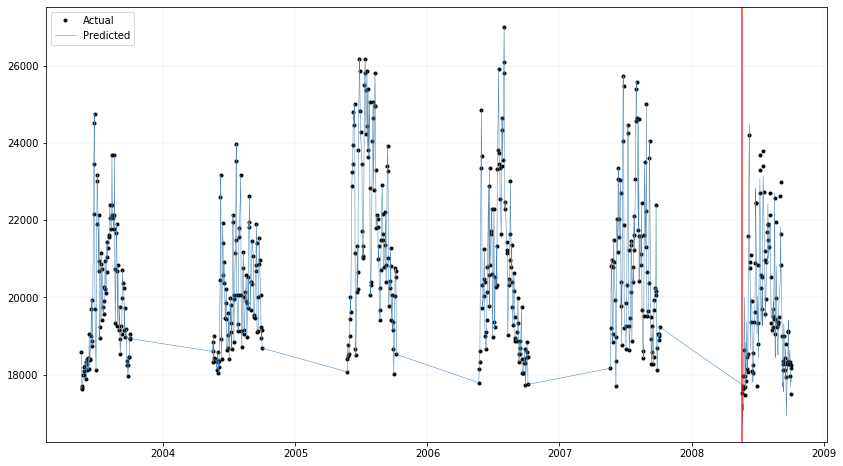

In [8]:
fig, ax = plot_prediction(pred_vals, goback_years=20)
plt.show();

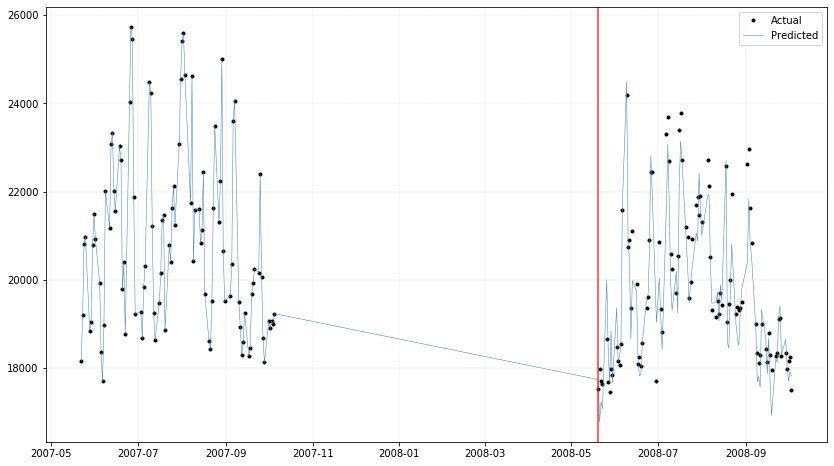

In [9]:
fig, ax = plot_prediction(pred_vals, goback_years=2)
plt.show();

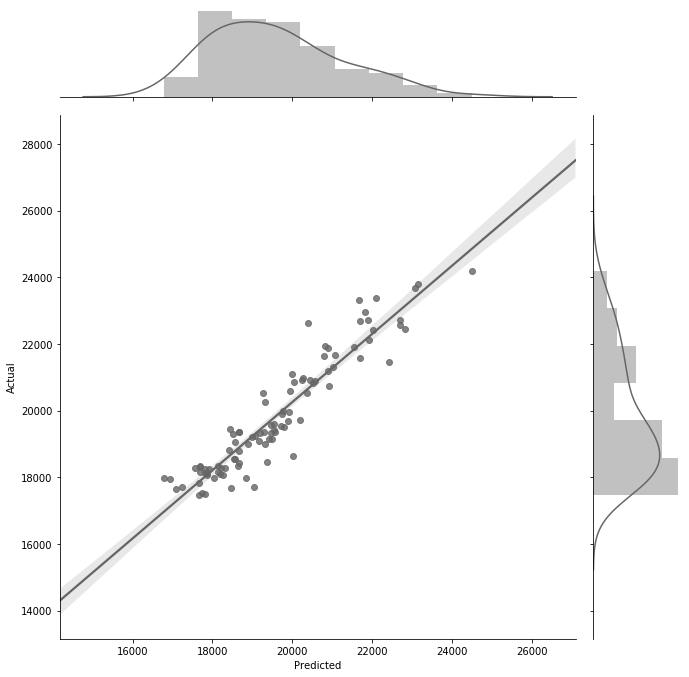

In [10]:
fig, ax = plot_joint_plot(pred_vals, goback_years=1)
plt.show();

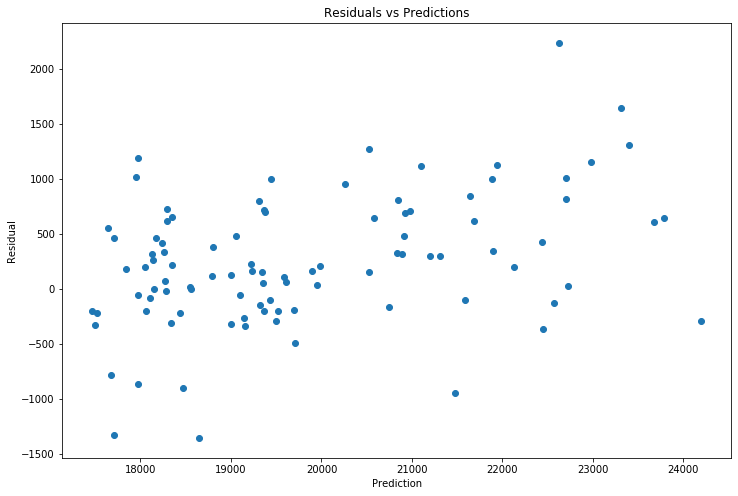

In [11]:
fig, ax = resids_vs_preds_plot(pred_vals)
plt.show()

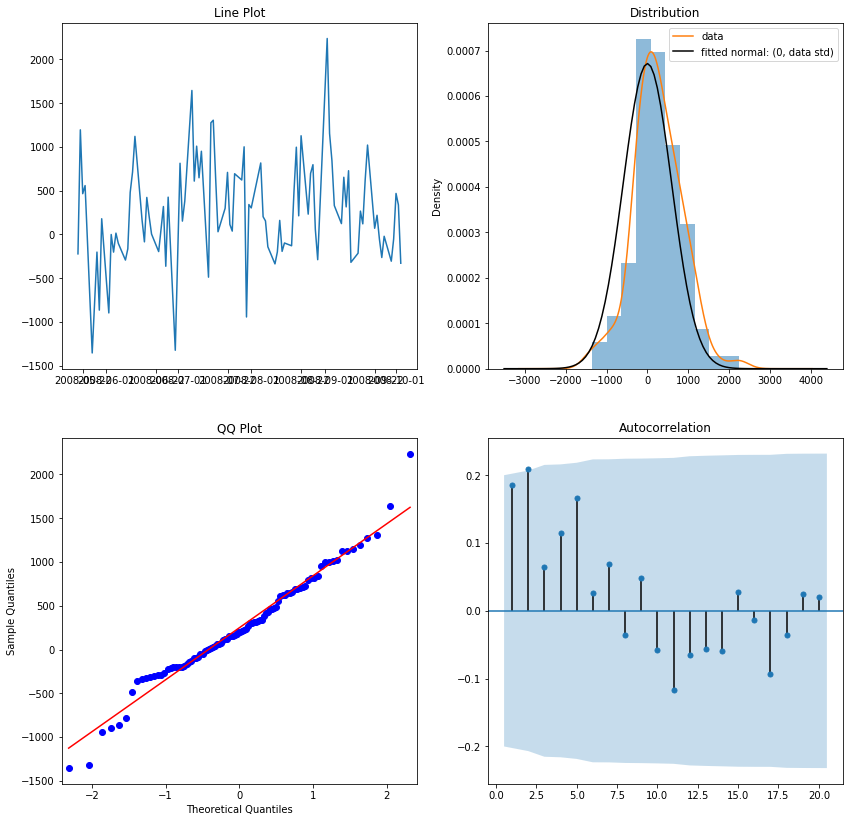

In [12]:
fig, ax = residual_plots(pred_vals)
plt.show()

In [13]:
print_residual_stats(pred_vals)

LJung Box Corr p value:		0.18334
Jarque Bera Normal p value:	0.13022


In [14]:
df = save_run_results(X, N_SPLITS, 'Prophet + KNeighborsRegressor', d, RESULTS_PATH)
df

'Model name already used'